# Zernike simulation and BO optimisation

## I. Visualisation of focal spots with Zernike terms 

adjust parameters and get the image of focal spots

In [1]:
from IPython.display import display, clear_output
import poppy
import matplotlib.pyplot as plt
from ipywidgets import widgets

RADIUS = 1.0  # meters
WAVELENGTH = 532e-9  # The wavelength of the laser used in Imperial Lab
PIXSCALE = 0.01  # arcsec / pix
FOV = 1  # arcsec
NUM_PARAMETERS = 10  # Number of Zernike parameters, try as many as you want!

def update_zernike_parameters(**params):
    clear_output(wait=True)  # Clear the output in Jupyter Notebook
    
    osys_intermediate = poppy.OpticalSystem()
    circular_aperture = poppy.CircularAperture(radius=RADIUS)
    osys_intermediate.add_pupil(circular_aperture)
    
    # Add the Zernike pupil with the current parameters
    coefficients_sequence = [params[f'Parameter_{i}']*10**-9 for i in range(NUM_PARAMETERS)]
    thin_lens_pupil = poppy.ZernikeWFE(radius=RADIUS, coefficients=coefficients_sequence)
    osys_intermediate.add_pupil(thin_lens_pupil)
    
    # Propagate the wavefront to the final stage
    osys_intermediate.add_detector(pixelscale=PIXSCALE, fov_arcsec=FOV)
    psf_intermediate = osys_intermediate.calc_psf(wavelength=WAVELENGTH)
    
    intermediate_psf = psf_intermediate[0].data
    
    plt.imshow(intermediate_psf, cmap='viridis', origin='lower')
    plt.colorbar()
    plt.title('Intermediate Intensity Distribution')
    plt.show()

# Set up interactive widgets for parameter adjustment
param_sliders = {f'Parameter_{i}': widgets.FloatSlider(value=0, min=-100, max=100, step=1, description=f'Parameter {i}')
                 for i in range(NUM_PARAMETERS)}

widgets.interact_manual(update_zernike_parameters, **param_sliders)


interactive(children=(FloatSlider(value=0.0, description='Parameter 0', min=-100.0, step=1.0), FloatSlider(val…

<function __main__.update_zernike_parameters(**params)>

## II. Quality analysis method

### a. intensity ratio method

Circle the centroid of beam and then calculate the ratio of  total intensity inside the circle and the total intensity outside the circle.

We need to find the best score of our perfect beam generated with all zero Zernike parameters then do the normalisation to make all scores to have values from  0-1. 

In this Zernike generator, our best ratio for perfect beam is 0.026351564288334666 with radius=1 circle.

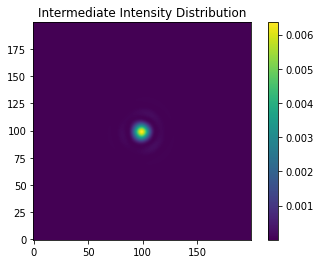

Parameters: [ 2.07267886 -2.70209845  9.25299173 -5.16886645  6.27182687 -0.14719382
 -6.99952257  7.00025948 -0.51241228 -2.42659896], Quality: 0.4797378344149873
Parameters: [-1.94541342 -7.23407075 -1.61596058  2.96750506  5.2928594  -6.98467031
  9.85504356 -7.40780328  8.31418581  4.59010886], Quality: 0.698972520466389
Parameters: [ 6.97318551  2.97054029 -6.46884911  3.99939125  1.18280766  8.25837651
  5.28810074  0.54745467 -6.75305892  2.63318452], Quality: 0.9703155150404282
Parameters: [ 1.18278477  6.13385824 -4.68641402 -6.18981934 -2.90113339 -5.02320624
  4.95429553  5.19717455 -1.29359795 -0.88193612], Quality: 0.9747275005412678
Parameters: [-3.37435537  7.6272482  -0.56124324 -1.83184901 -2.10718937  8.30655951
 -3.94547335  7.11640663 -0.15734094  0.94344236], Quality: 0.7313907640359973
Parameters: [ 5.97914759  9.22595262  0.65439369  7.99203693  0.83558882 -9.90115157
 -0.42787755  0.68944914 -0.27634588 -4.76119603], Quality: 0.9733151531386659
Parameters: [-0.9

In [41]:
import numpy as np
from scipy.ndimage import center_of_mass

# Step 1: Function to Generate Random Zernike Parameters
def generate_random_parameters(num_parameters):
    return np.random.uniform(low=-10, high=10, size=num_parameters) # low Zernike terms
    # return np.random.uniform(low=-100, high=100, size=num_parameters) # high Zernike terms
    # return np.zeros(num_parameters) #zero Zernike terms to get best ratio for perfect beam

#Step 2: Function for Quality Analysis
def analyze_quality(psf):
    # Find the centroid of the PSF
    y, x = center_of_mass(psf)

    # Define a circle around the centroid
    radius = 1  # You can adjust the radius as needed
    yy, xx = np.ogrid[:psf.shape[0], :psf.shape[1]]
    circle = (yy - y)**2 + (xx - x)**2 <= radius**2

    # Calculate the total intensity inside and outside the circle
    total_intensity_inside = np.sum(psf[circle])
    total_intensity_outside = np.sum(psf[~circle])

    # Calculate the intensity ratio as a quality metric (normalized to [0, 1])
    intensity_ratio = total_intensity_inside / (total_intensity_inside + total_intensity_outside)
    intensity_ratio_normalised= intensity_ratio/0.026351564288334666 # Normalised to the intensity ratio of the perfect PSF
    return intensity_ratio_normalised

# Step 3: Loop Over Random Focal Spots
NUM_RANDOM_SPOTS = 10  # Adjust the number of random spots as needed

random_spot_results = []

for _ in range(NUM_RANDOM_SPOTS):
    # Generate random parameters
    random_params = generate_random_parameters(NUM_PARAMETERS)

    # Update Zernike parameters and display intermediate PSF
    update_zernike_parameters(**{f'Parameter_{i}': param for i, param in enumerate(random_params)})

    # Propagate the wavefront to the final stage and get PSF
    osys_final = poppy.OpticalSystem()
    circular_aperture = poppy.CircularAperture(radius=RADIUS)
    osys_final.add_pupil(circular_aperture)
    
    thin_lens_pupil = poppy.ZernikeWFE(radius=RADIUS, coefficients=random_params*10**-9)
    osys_final.add_pupil(thin_lens_pupil)
    
    osys_final.add_detector(pixelscale=PIXSCALE, fov_arcsec=FOV)
    psf_final = osys_final.calc_psf(wavelength=WAVELENGTH)[0].data

    # Perform quality analysis
    quality_metric = analyze_quality(psf_final)

    # Store the results
    random_spot_results.append({'Parameters': random_params, 'Quality': quality_metric})

# Print or further analyze the results
for result in random_spot_results:
    print(f"Parameters: {result['Parameters']}, Quality: {result['Quality']}")


## III. Optimisation

### 1. BO

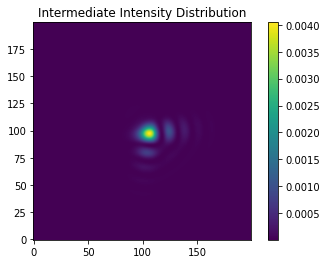

Best Parameters: [-43.61397341335965, -29.45948354057309, 41.78073776437935, -22.105496861356897, 19.417197771545915, -13.541360124650097, 28.190685078295928, -37.630831809250154, 16.543284651424443, -31.541850042091852]
Best Quality: 0.31929388006416315


In [53]:
from skopt import gp_minimize
from skopt.space import Real

# Define the objective function
def objective_function(params):
    # Extract Zernike parameters
    zernike_params = np.array(params)

    # Update Zernike parameters and calculate PSF
    update_zernike_parameters(**{f'Parameter_{i}': param for i, param in enumerate(zernike_params)})

    # Propagate the wavefront to the final stage and get PSF
    osys_final = poppy.OpticalSystem()
    circular_aperture = poppy.CircularAperture(radius=RADIUS)
    osys_final.add_pupil(circular_aperture)

    thin_lens_pupil = poppy.ZernikeWFE(radius=RADIUS, coefficients=zernike_params*10**-9)
    osys_final.add_pupil(thin_lens_pupil)

    osys_final.add_detector(pixelscale=PIXSCALE, fov_arcsec=FOV)
    psf_final = osys_final.calc_psf(wavelength=WAVELENGTH)[0].data

    # Perform quality analysis
    quality_metric = analyze_quality(psf_final)

    return -quality_metric  # Negative because skopt performs minimization

# Define the parameter space
param_space = [Real(-100, 100, name=f'Parameter_{i}') for i in range(NUM_PARAMETERS)]



# Run Bayesian optimization
# Run Bayesian optimization without parallelization
result = gp_minimize(objective_function, param_space, n_calls=50, random_state=42, n_jobs=1)


# Print the best parameters and corresponding quality
best_params = result.x
best_quality = -result.fun  # Remember to negate the score because skopt performs minimization
print("Best Parameters:", best_params)
print("Best Quality:", best_quality)



It works, now compare with random search with same initial parameters.

### 2. BO vs random search

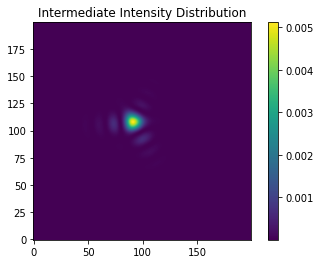

Iteration No: 250 ended. Search finished for the next optimal point.
Time taken: 10.8377
Function value obtained: -0.7485
Current minimum: -0.9177


In [98]:
from skopt import gp_minimize
from skopt.space import Real
import numpy as np
import plotly.graph_objects as go

# Define the parameter space
param_space = [Real(-100, 100, name=f'Parameter {i}') for i in range(10)]

# Initial set of parameters
initial_params = [0.0, 53.0, 0.0, 66.0, -68.0, 0.0, 48.0, -50.0, 79.0, -16.0]

# Number of runs
num_runs = 5

# Lists to store results
bayesian_results = []
random_results = []

for run in range(num_runs):
    # Run the optimization with Gaussian process regressor
    bayesian_search_results = gp_minimize(
        objective_function,
        dimensions=param_space,
        n_calls=250,
        verbose=True,
        n_random_starts=20,
        n_initial_points=20,
        x0=[initial_params]
    )

    # Run the optimization with random search
    random_search_results = gp_minimize(
        objective_function,
        dimensions=param_space,
        n_calls=250,
        verbose=True,
        n_random_starts=20,
        n_initial_points=20,
        n_jobs=1,
        x0=[initial_params]
    )

    # Extract the results
    bayesian_results.append(-bayesian_search_results.func_vals)
    random_results.append(-random_search_results.func_vals)

# Calculate mean and standard deviation for each iteration
bayesian_mean = np.mean(bayesian_results, axis=0)
bayesian_std = np.std(bayesian_results, axis=0)
random_mean = np.mean(random_results, axis=0)
random_std = np.std(random_results, axis=0)

# Plot the results with error bars
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=np.arange(1, len(bayesian_mean) + 1),
    y=bayesian_mean,
    mode='lines+markers',
    name='Bayesian Optimization',
    error_y=dict(type='data', array=bayesian_std, visible=True),
))

fig.add_trace(go.Scatter(
    x=np.arange(1, len(random_mean) + 1),
    y=random_mean,
    mode='lines+markers',
    name='Random Search',
    error_y=dict(type='data', array=random_std, visible=True),
))

fig.update_layout(
    title='Quality vs Iteration',
    xaxis=dict(title='Iteration'),
    yaxis=dict(title='Quality'),
    showlegend=True
)

fig.show()


Text(0.5, 1.0, 'Quality vs Iteration for Bayesian and Random Search')

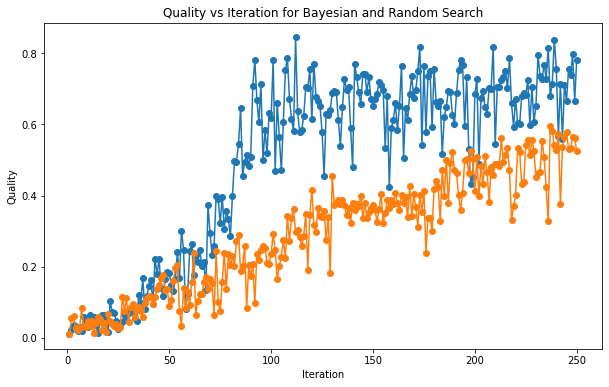

In [101]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(bayesian_mean) + 1), bayesian_mean, marker='o', label='Bayesian Search')
plt.plot(range(1, len(random_mean) + 1), random_mean, marker='o', label='Random Search')
plt.xlabel('Iteration')
plt.ylabel('Quality')
plt.title('Quality vs Iteration for Bayesian and Random Search')

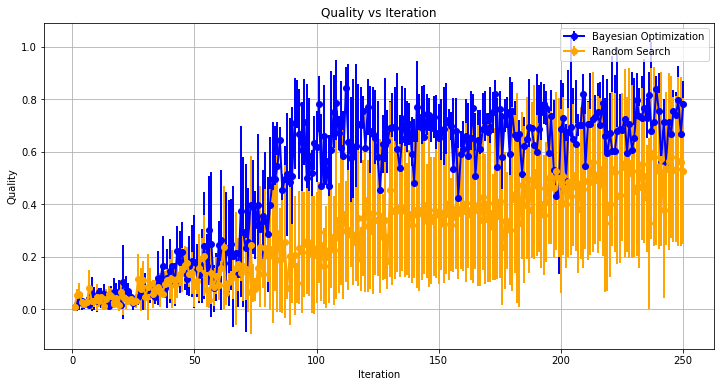

In [102]:
# Plot the results with error bars using plt
plt.figure(figsize=(12, 6))

# Bayesian Optimization
plt.errorbar(
    x=np.arange(1, len(bayesian_mean) + 1),
    y=bayesian_mean,
    yerr=bayesian_std,
    label='Bayesian Optimization',
    fmt='-o',
    color='blue',
    linewidth=2
)

# Random Search
plt.errorbar(
    x=np.arange(1, len(random_mean) + 1),
    y=random_mean,
    yerr=random_std,
    label='Random Search',
    fmt='-o',
    color='orange',
    linewidth=2
)

plt.xlabel('Iteration')
plt.ylabel('Quality')
plt.title('Quality vs Iteration')
plt.legend()
plt.grid(True)
plt.show()


Finally! BO beat random search!